# Single cloud type segmentation
In this notebook, only the *flower* cloud category is considered.  The plan is to train a model that can predict the mask for flower clouds.

In [7]:
import sys
sys.path.append('/home/jupyter/fastai_dev/dev')

from local.data.all import *
from local.vision.core import *
from local.vision.augment import *

## Data 
In this section, a DataBunch for training will be created from the dataset.

### Load the images (their file paths) and the labels (the annotations)

In [8]:
SOURCE = Path('data/train_images')

In [9]:
items = get_image_files(SOURCE)

In [10]:
items

(#5546) [data/train_images/0a7a247.jpg,data/train_images/2f52d76.jpg,data/train_images/6b272fe.jpg,data/train_images/01eecc1.jpg,data/train_images/f3dad96.jpg,data/train_images/93aafb4.jpg,data/train_images/f157992.jpg,data/train_images/4fa9d86.jpg,data/train_images/c71b0dc.jpg,data/train_images/547ad87.jpg...]

In [11]:
IMG_SHAPE = PILImage.create(items[12]).shape

In [12]:
def load_train_annotation(fpath):
    df = pd.read_csv(fpath)
    df['Image'] = df.Image_Label.apply(lambda o: o.split('.')[0])
    df['Label'] = df.Image_Label.apply(lambda o: o.split('_')[1].lower())
    df.drop('Image_Label', axis=1, inplace=True)
    df = df[['Image', 'Label', 'EncodedPixels']]
    return df

In [13]:
annots = load_train_annotation('data/train.csv')

### Rescaling the images
The original size of the images is 2100 px in width and 1400 px in height.  To start off with something smaller, a `Transform` is created for rescaling the images.  Here, the aspect ratio is kept the same, so no cropping or squishing.

In [14]:
im = PILImage.create(items[10])
im.size

(2100, 1400)

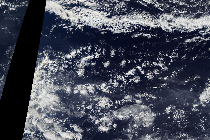

In [15]:
Transform(lambda o: Image.Image.resize_max(o, max_w=210))(im)

In [16]:
class RescaleTfm(Transform):
    def __init__(self, max_w=210, resample=Image.BILINEAR): 
        self.max_w, self.resample = max_w, resample
        
    def encodes(self, o:PILImage): return o.resize_max(max_w=self.max_w, resample=self.resample)
    def encodes(self, o:PILMask): return o.resize_max(max_w=self.max_w, resample=Image.NEAREST)


In [17]:
rescale = RescaleTfm(max_w=210, resample=0)

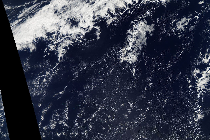

In [18]:
rescale(PILImage.create(items[8]))

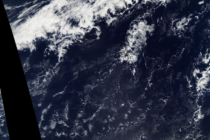

In [19]:
RescaleTfm(max_w=210, resample=Image.BILINEAR)(PILImage.create(items[8]))

The difference between `resample=0` and `resample=Image.BILINEAR` can be seen above.  For now, `resample=0` will be used.  And the width is reduced to 210 px.  This `Transform` will be used   when creating the `DataBunch` below.

In [20]:
SZ = 210

In [21]:
rescale = RescaleTfm(max_w=SZ, resample=0)

### DataSource

A `Transform` is created that will transform an image file path to its *flower* cloud mask, a `np.array`.  The downloaded train set is split randomly into a train and valid set, using `RandomSplitter`.

In [22]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    
    Copied from https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [23]:
CAT = 'flower'

In [24]:
class RLE_Decode(Transform):
    def __init__(self, annots, img_shape): self.annots, self.img_shape = annots, img_shape
        
    def encodes(self, o):
        df = self.annots[self.annots.Image == o.stem].fillna('')
        pxenc = df[df.Label == CAT].EncodedPixels.values[0]
        return rle_decode(pxenc, self.img_shape)

In [25]:
split_idx = RandomSplitter()(items)
tfms = [[PILImage.create, ], 
        [RLE_Decode(annots, IMG_SHAPE), PILMask.create]]
dsrc = DataSource(items, tfms=tfms, splits=split_idx)

### DataBunch
Convert the `DataSource` into a `DataBunch`, which is the object that can load mini-batches for training.  In the process, additional data transformations are specified.  

In [26]:
item_img_tfms = [RescaleTfm(max_w=SZ, resample=0), ToTensor,]

In [27]:
batch_tfms = [Cuda(), IntToFloatTensor(),]

In [28]:
dbch = dsrc.databunch(after_item=item_img_tfms, after_batch=batch_tfms, bs=4)

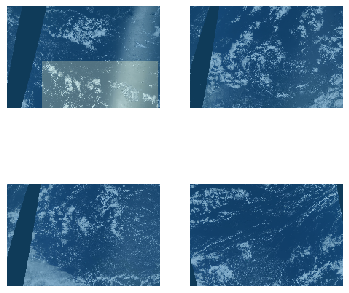

In [29]:
dbch.show_batch()

### Image normalization
Find the mean and standard deviation for each colour channel, from a batch of images.  These stats are used to form a `Normalize` transform.  The `DataBunch` is re-created with the addition of this `Transform`.

In [126]:
dbch = dsrc.databunch(after_item=item_img_tfms, after_batch=batch_tfms, bs=64)

In [127]:
xb, yb = dbch.one_batch()

In [135]:
xb.shape, yb.shape, IMG_SZ

(torch.Size([64, 3, 1400, 2100]), torch.Size([64, 1400, 2100]), (1400, 2100))

In [128]:
cloud_stats = [xb.mean(dim=[0, 2, 3]), xb.std(dim=[0, 2, 3])]
cloud_stats

[tensor([0.2665, 0.2844, 0.3323]), tensor([0.2578, 0.2532, 0.2383])]

Mean: [0.2556, 0.2727, 0.3182]  
Standard deviation:  [0.2475, 0.2429, 0.2294]

In [30]:
cloud_stats = [tensor([0.2556, 0.2727, 0.3182]), tensor([0.2475, 0.2429, 0.2294])]

In [31]:
cloud_stats = broadcast_vec(1, 4, *cloud_stats)

In [32]:
cloud_stats[0].shape, cloud_stats[1].shape

(torch.Size([1, 3, 1, 1]), torch.Size([1, 3, 1, 1]))

In [33]:
batch_tfms += [Normalize(*cloud_stats)]
dbch = dsrc.databunch(bs=4, after_item=item_img_tfms, after_batch=batch_tfms)

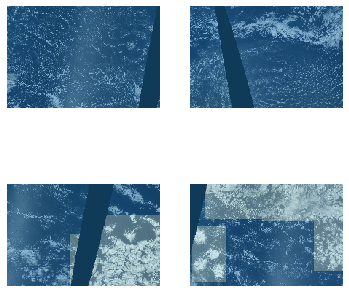

In [34]:
dbch.show_batch()

In [35]:
xb, yb = dbch.one_batch()

In [36]:
xb.mean(dim=[0, 2, 3]), xb.std(dim=[0, 2, 3])

(tensor([-0.0792, -0.0792, -0.0889], device='cuda:0'),
 tensor([0.9354, 0.9387, 0.9506], device='cuda:0'))

In [37]:
xb.shape, yb.shape

(torch.Size([4, 3, 140, 210]), torch.Size([4, 140, 210]))

Now, the `DataBunch` loads mini-batches of size 4, where the images and masks have a width of 210 px, with the original aspect ratio.

## Model
UNet.

In [38]:
from local.vision.models import resnet34
from local.vision.models.unet import DynamicUnet

In [90]:
DynamicUnet??

In [39]:
xb.shape[-2:]

torch.Size([140, 210])

In [40]:
m = resnet34(pretrained=True)
m = nn.Sequential(*list(m.children())[:-2])
model = DynamicUnet(encoder=m, n_classes=2, img_size=xb.shape[-2:], norm_type=None)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 100MB/s] 


In [41]:
%%timeit
x = torch.randn(4, 3, 140, 210)
y = model(x)

598 ms ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
y.shape

torch.Size([4, 2, 140, 210])

In [43]:
xb, yb = dbch.one_batch()

In [47]:
model.cuda()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [48]:
%%timeit

pred = model(xb)

The slowest run took 6.64 times longer than the fastest. This could mean that an intermediate result is being cached.
21.4 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
pred = model(xb)

In [50]:
pred.shape, yb.shape

(torch.Size([4, 2, 140, 210]), torch.Size([4, 140, 210]))

In [51]:
pred[0, 0]

tensor([[ 0.1468,  0.1824,  0.0774,  ...,  0.1409,  0.2327, -0.2033],
        [ 0.3149,  0.7378,  0.4919,  ...,  0.5361,  0.0384,  0.0815],
        [ 0.7482,  0.9796,  0.8367,  ...,  0.8535,  0.2823,  0.2051],
        ...,
        [-0.0951, -0.1788,  0.2766,  ...,  0.7652,  0.2670,  0.5174],
        [ 0.0018, -0.2861,  0.2639,  ...,  0.4553,  0.0562,  0.3192],
        [-0.0033, -0.0590,  0.2990,  ...,  0.6198,  0.3133,  0.2781]],
       device='cuda:0', grad_fn=<SelectBackward>)

## Loss function
The loss function that will be used here is, specifically, `OpenMask.loss_func`.  Its description can be found at: https://pytorch.org/docs/stable/nn.html?highlight=cross%20entropy%20loss#torch.nn.CrossEntropyLoss.

In [52]:
yb.shape, pred.shape

(torch.Size([4, 140, 210]), torch.Size([4, 2, 140, 210]))

In [53]:
yb.unique()

tensor([0, 1], device='cuda:0')

In [54]:
OpenMask.loss_func(pred, yb)

tensor(0.5380, device='cuda:0', grad_fn=<NllLossBackward>)

In [55]:
nn.CrossEntropyLoss()(pred, yb)

tensor(0.5380, device='cuda:0', grad_fn=<NllLoss2DBackward>)

## Metrics
The percentage of correctly classified pixels will used as a metric.  

In [56]:
def acc_seg(input, target): return (input.argmax(dim=1) == target).float().mean()

In [57]:
acc_seg(pred, yb)

tensor(0.7645, device='cuda:0')

## Learner

In [58]:
from local.basics import *
from local.vision.all import *

In [59]:
learn = Learner(dbch, model, loss_func=OpenMask.loss_func, lr=1e-2, metrics=acc_seg)

In [60]:
learn.fit_one_cycle(n_epoch=1)

epoch,train_loss,valid_loss,acc_seg,time
0,0.579538,0.372295,0.870519,03:36


In [61]:
learn.save('quick_first_1epoch');

# End